# **Muhamad Gatot Supiadin**
## M183X0343 | M01 - Pengembangan Machine Learning dan Front End Web
## Universitas Amikom Yogyakarta , Sleman Yogyakarta

## **Time Series-(Gold)**

In [13]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM, Bidirectional, Dropout
import matplotlib.pyplot as plt
import tensorflow as tf

In [15]:
df = pd.read_csv('gold.csv')
df

,Date,Open,High,Low,Close,Volume,Currency
0,2000-01-04,289.5,289.5,280.0,283.7,21621,USD
1,2000-01-05,283.7,285.0,281.0,282.1,25448,USD
2,2000-01-06,281.6,282.8,280.2,282.4,19055,USD
3,2000-01-07,282.5,284.5,282.0,282.9,11266,USD
4,2000-01-10,282.4,283.9,281.8,282.7,30603,USD
...,...,...,...,...,...,...,...
5693,2022-08-22,1760.6,1762.1,1740.2,1748.4,142857,USD
5694,2022-08-23,1750.0,1767.5,1743.1,1761.2,145260,USD
5695,2022-08-24,1761.3,1769.5,1754.8,1761.5,112645,USD
5696,2022-08-25,1764.4,1778.8,1763.0,1771.4,117570,USD


In [16]:
df.shape

(5698, 7)

In [17]:
df.isnull().sum()

Date        0
Open        0
High        0
Low         0
Close       0
Volume      0
Currency    0
dtype: int64

In [18]:
cols = [0,1]
df = df[df.columns[cols]]
df

,Date,Open
0,2000-01-04,289.5
1,2000-01-05,283.7
2,2000-01-06,281.6
3,2000-01-07,282.5
4,2000-01-10,282.4
...,...,...
5693,2022-08-22,1760.6
5694,2022-08-23,1750.0
5695,2022-08-24,1761.3
5696,2022-08-25,1764.4


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5698 entries, 0 to 5697
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    5698 non-null   object 
 1   Open    5698 non-null   float64
dtypes: float64(1), object(1)
memory usage: 89.2+ KB


**Making Plot**

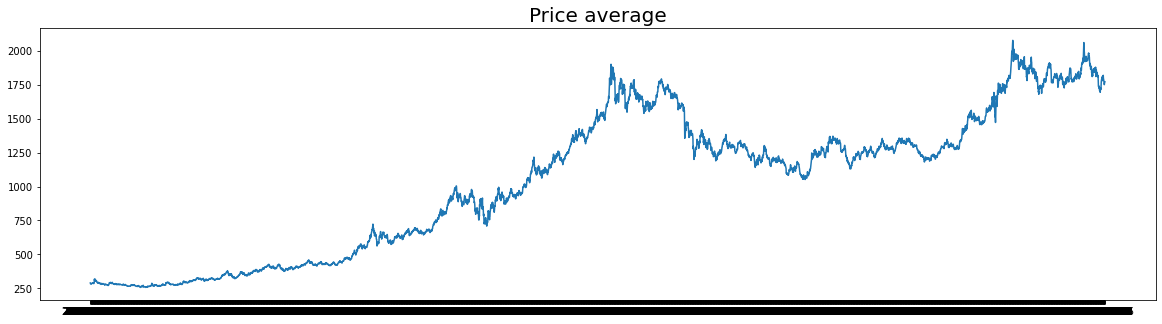

In [8]:
dates = df['Date'].values
prices  = df['Open'].values
 
 
plt.figure(figsize=(20,5))
plt.plot(dates, prices)
plt.title('Price average',
          fontsize=20);

**Converting Data**

In [23]:
from sklearn.preprocessing import MinMaxScaler
prices = prices.reshape(-1, 1)

mm_scaler = MinMaxScaler()
scaled_prices = mm_scaler.fit_transform(prices)
scaled_prices = scaled_prices.reshape(1, -1)
scaled_prices = np.hstack(scaled_prices)
scaled_prices

array([0.01807891, 0.01489175, 0.01373777, ..., 0.8268491 , 0.82855259,
       0.83261897])

**Splitting Dataset**

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dates, 
                                                    scaled_prices, 
                                                    test_size=0.2, 
                                                    random_state=1, 
                                                    shuffle=False)

print(len(X_train), len(X_test))

4558 1140


In [27]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [21]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [47]:
train_set = windowed_dataset(y_train, window_size=64,
                             batch_size=200,
                             shuffle_buffer=1000)

val_set = windowed_dataset(y_test, window_size=64,
                           batch_size=200,
                           shuffle_buffer=1000)

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.LSTM(60),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [48]:
scale = (max(scaled_prices) - min(scaled_prices)) * 0.1
print(scale)

0.1


**Making Callbacks**

In [49]:
class CallbackTS(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')< scale) and (logs.get('val_mae') < scale):
      self.model.stop_training = True
      print('\nFor Epoch', epoch, ' training has been stopped.''\n Because MAE of the model has reach < 10% of data scale')
callbacks = CallbackTS()

**Train Model**

In [50]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set,
                    epochs=100,
                    validation_data=val_set, 
                    callbacks=[callbacks])

Epoch 1/100
23/23 [==============================] - 15s 231ms/step - loss: 0.0859 - mae: 0.3368 - val_loss: 0.2513 - val_mae: 0.6965
Epoch 2/100
23/23 [==============================] - 5s 188ms/step - loss: 0.0719 - mae: 0.3018 - val_loss: 0.2150 - val_mae: 0.6426
Epoch 3/100
23/23 [==============================] - 5s 221ms/step - loss: 0.0557 - mae: 0.2645 - val_loss: 0.1754 - val_mae: 0.5782
Epoch 4/100
23/23 [==============================] - 5s 193ms/step - loss: 0.0434 - mae: 0.2401 - val_loss: 0.1449 - val_mae: 0.5232
Epoch 5/100
23/23 [==============================] - 5s 195ms/step - loss: 0.0356 - mae: 0.2232 - val_loss: 0.1223 - val_mae: 0.4785
Epoch 6/100
23/23 [==============================] - 5s 192ms/step - loss: 0.0306 - mae: 0.2121 - val_loss: 0.1055 - val_mae: 0.4425
Epoch 7/100
23/23 [==============================] - 5s 191ms/step - loss: 0.0274 - mae: 0.2050 - val_loss: 0.0929 - val_mae: 0.4134
Epoch 8/100
23/23 [==============================] - 5s 190ms/step -

**Mae plot visualisation**

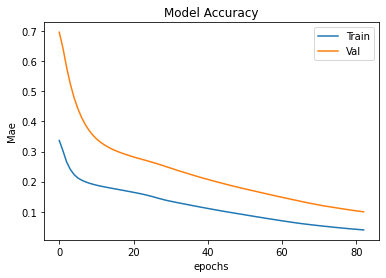

In [51]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model Accuracy')
plt.ylabel('Mae')
plt.xlabel('epochs')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

**Loss plot Visualisation**

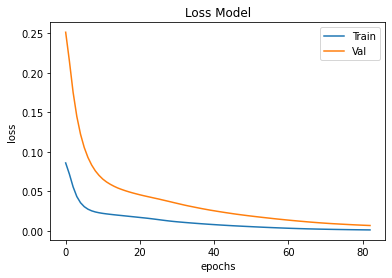

In [52]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()